In [37]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from skimage.io import imread
from skimage.color import rgb2gray

training_file = '../train.p' 
validation_file = '../valid.p'
testing_file = '../test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


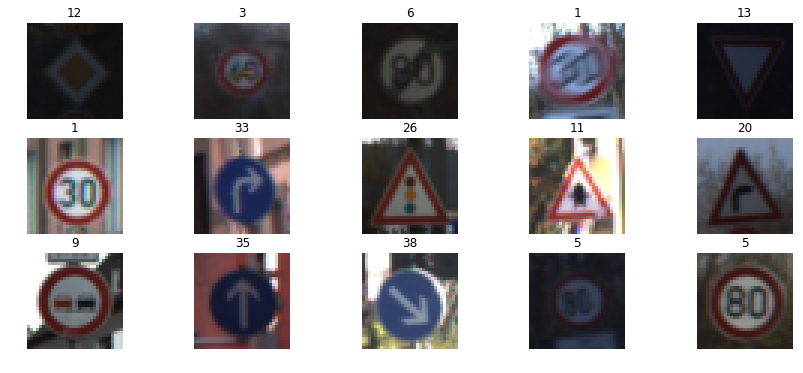

In [38]:
fig, axs = plt.subplots(3,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(15):
    image = X_train[i]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[i])
plt.show()

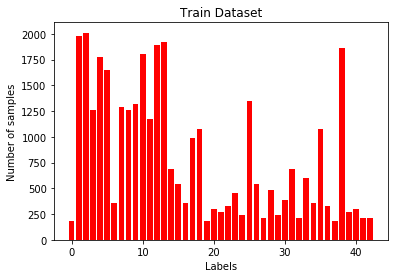

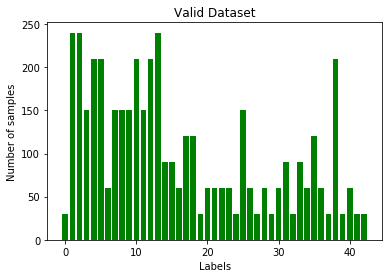

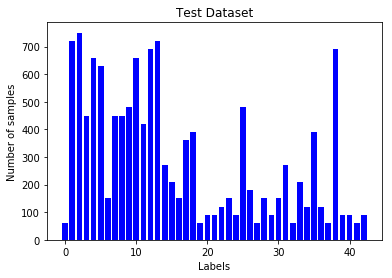

In [39]:
#Summary
#Label Visualization
u_train, counts_train = np.unique(y_train, return_counts=True)
plt.bar(u_train, counts_train, align = 'center', color ='r',width = 0.8)
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title("Train Dataset")
plt.savefig('Train Dataset')
plt.show()

u_valid, counts_train = np.unique(y_valid, return_counts=True)
plt.bar(u_valid, counts_train, align = 'center', color ='g', width = 0.8)
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title("Valid Dataset")
plt.savefig('Valid Dataset')
plt.show()

u_test, counts_train = np.unique(y_test, return_counts=True)
plt.bar(u_test, counts_train, align = 'center', color ='b', width = 0.8)
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title("Test Dataset")
plt.savefig('Test Dataset')
plt.show()

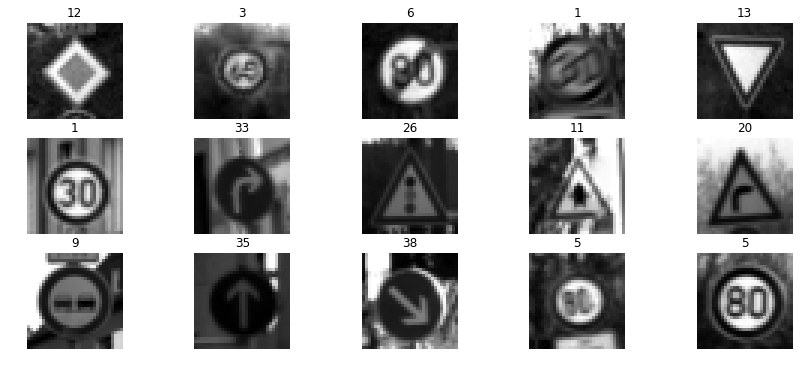

Shapes on which the mopdel is to be run
(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [40]:
##Pre-Processing
## Grayscale
X_tgray = rgb2gray(X_train)
X_vgray = rgb2gray(X_valid)
X_testgray = rgb2gray(X_test)

# Diplay the grayscale image
fig, axs = plt.subplots(3,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(15):
    image = X_tgray[i]
    axs[i].axis('off')
    axs[i].imshow(image,cmap = 'gray')
    axs[i].set_title(y_train[i])
plt.show()

#Normalisation
X_train = (X_tgray - np.mean(X_tgray))/np.std(X_tgray)
X_valid = (X_vgray - np.mean(X_vgray))/np.std(X_vgray)
X_test = (X_testgray - np.mean(X_testgray))/np.std(X_testgray)

X_train = np.expand_dims(X_train, axis=3)
X_valid = np.expand_dims(X_valid, axis=3)
X_test = np.expand_dims(X_test,axis = 3)

print('Shapes on which the mopdel is to be run')
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

In [49]:
def Arch(x):    

    mu = 0
    sigma = 0.1
    
    # 1st convolution layer 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    
    # 2nd Convolution 
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 10, 20), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(20))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    # Max_pool and dropout on 2nd layer
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2   = tf.nn.dropout(conv2, keep_prob)    
    
    # 3rd Convolution
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 20, 40), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(40))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    # Dropout on 3rd layer
    conv3   = tf.nn.dropout(conv3,keep_prob)
    
    # 4th Convolution 
    conv4_w = tf.Variable(tf.truncated_normal(shape=(3, 3, 40, 80), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(80))
    conv4   = tf.nn.conv2d(conv3, conv4_w,  strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4   = tf.nn.relu(conv4)
    # Max_pool and dropout on 4th layer
    conv4   = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4   = tf.nn.dropout(conv4, keep_prob)    
    
    #Flattening
    fc0   = flatten(conv4)
    
    #Fully Connected
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2000, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    # Dropout
    fc1   = tf.nn.dropout(fc1,keep_prob)
    
    #Fully Connected layer 2
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    
    #Fully Connected layer 3
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [50]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
rate = 0.0011

logits = Arch(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def eval_loss(X_data, y_data):
    num_examples = len(X_data)
    loss_f = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
        loss_f += loss*len(batch_x)
    return loss_f / num_examples

In [54]:
EPOCHS = 30
BATCH_SIZE = 128
T_loss = []
Train_Acc = []
Valid_Acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
                   
        train_accuracy = evaluate(X_train,y_train)
        Train_Acc.append(train_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid)
        Valid_Acc.append(validation_accuracy)
        
        train_loss = eval_loss(X_train,y_train)
        T_loss.append(train_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
        
    saver.save(sess, './version1')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.640
Validation Accuracy = 0.604

EPOCH 2 ...
Train Accuracy = 0.881
Validation Accuracy = 0.854

EPOCH 3 ...
Train Accuracy = 0.944
Validation Accuracy = 0.917

EPOCH 4 ...
Train Accuracy = 0.963
Validation Accuracy = 0.933

EPOCH 5 ...
Train Accuracy = 0.978
Validation Accuracy = 0.956

EPOCH 6 ...
Train Accuracy = 0.981
Validation Accuracy = 0.951

EPOCH 7 ...
Train Accuracy = 0.985
Validation Accuracy = 0.966

EPOCH 8 ...
Train Accuracy = 0.988
Validation Accuracy = 0.977

EPOCH 9 ...
Train Accuracy = 0.988
Validation Accuracy = 0.967

EPOCH 10 ...
Train Accuracy = 0.992
Validation Accuracy = 0.973

EPOCH 11 ...
Train Accuracy = 0.993
Validation Accuracy = 0.973

EPOCH 12 ...
Train Accuracy = 0.992
Validation Accuracy = 0.976

EPOCH 13 ...
Train Accuracy = 0.994
Validation Accuracy = 0.973

EPOCH 14 ...
Train Accuracy = 0.995
Validation Accuracy = 0.973

EPOCH 15 ...
Train Accuracy = 0.995
Validation Accuracy = 0.973

EPOCH 16 ...
Train Ac

In [56]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.972


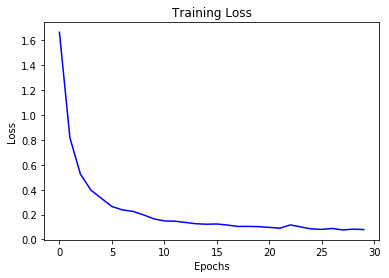

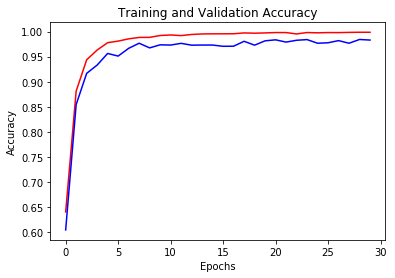

In [58]:
import math
#epoch = linspace(0,EPOCHS)

t = np.arange(0.0,EPOCHS)
plt.plot(t,T_loss,'b')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Train_loss_graph')
plt.show()

plt.plot(t,Train_Acc,'r')
plt.plot(t,Valid_Acc,'b')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Accuracy')
plt.show()


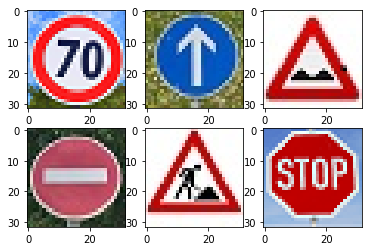

In [60]:
pics = []
for i in range(1,7):
    location = 'Data/'
    location += str(i)+'.png'
    img = mpimg.imread(location)
    pics.append(img)

pics = np.array(pics)
pics_g = rgb2gray(pics)
test_pics = (pics_g - np.mean(pics_g))/np.std(pics_g)
test_pics = np.expand_dims(pics_g, axis = 3)

fig = plt.figure()
for i in range(1,7):
    fig.add_subplot(2,3,i)
    plt.imshow(pics[i-1],cmap = 'gray')
    plt.savefig('ihg')
plt.show()

In [61]:
pics_label = [4,35,22,17,25,14]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.argmax(logits, 1), feed_dict={x: test_pics, y: pics_label, keep_prob: 1.0})
    print("", OUT, "<-predictions")
    print("", pics_label, "<-actual")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: test_pics, y: pics_label, keep_prob: 1.0})
    print(OUT[1].T)
    print("(top  5 predictions above) for each image")
   
    print()    
    print("probability for top 5 predictions for each image:")
    for i in range(len(pics_label)):
        print(i, OUT[0][i].T)


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_pics_accuracy = evaluate(test_pics, pics_label )
    print("Test Accuracy = {:.3f}".format(test_pics_accuracy))
    

 [ 4 35 22 17 25 14] <-predictions
 [4, 35, 22, 17, 25, 14] <-actual
[[ 4 35 22 17 25 14]
 [ 1 36 29  9 30  3]
 [ 0 34 28 40 24 38]
 [ 2  3 31 34 31  5]
 [15 12 18 12 29 34]]
(top  5 predictions above) for each image

probability for top 5 predictions for each image:
0 [  9.99677062e-01   1.92583830e-04   1.12182512e-04   1.51593067e-05
   7.79633126e-07]
1 [  9.99997616e-01   1.95363805e-06   2.09032137e-07   1.17683904e-07
   7.79265719e-08]
2 [  9.99965429e-01   3.45447297e-05   7.02063616e-08   1.30251250e-08
   4.19084456e-09]
3 [  9.99998689e-01   9.96259587e-07   2.45354130e-07   5.18857917e-08
   2.02538786e-08]
4 [  9.99891639e-01   3.78689547e-05   2.65996550e-05   2.02968313e-05
   1.00123170e-05]
5 [  9.99930501e-01   2.82507954e-05   1.22250431e-05   6.47725938e-06
   4.38485267e-06]
Test Accuracy = 1.000
